# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [3]:
#open the files
train_data = pd.read_csv('Bikeshare_train.csv', sep=",", header=0)
test_data = pd.read_csv('Bikeshare_test.csv', sep=",", header=0)

#For a while, we thought a malfunction in our code was being caused by overloading the reserved word "count"
#This turned out not to be the case, but after it was already changed, we just left it.
train_data.rename(index=str, columns={"count": "rentals"}, inplace=True)
test_data.rename(index=str, columns={"count": "rentals"}, inplace=True)
train_data
test_data

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


In [4]:
print(train_data.dtypes)
pd.set_option('display.max_rows', 500)
test_data

Unnamed: 0       int64
season         float64
month          float64
holiday        float64
day_of_week    float64
workingday     float64
weather        float64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
rentals        float64
dtype: object


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


your answers here

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

Avg rentals on a non-working day:  4461.073394495413
Avg rentals on a working day:  4665.896396396396


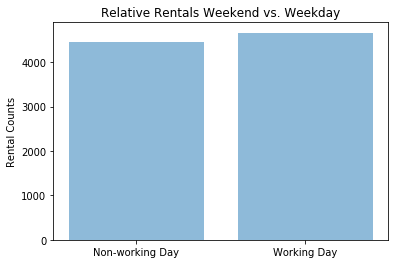

Avg rentals on holiday:  4612.171875
Avg rentals on non-holiday:  4199.181818181818


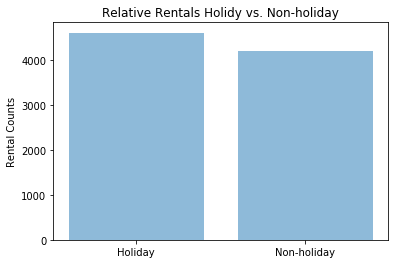

Avg rentals for each season:  [2210.0, 5044.4, 5680.738636363636, 5602.041666666667]


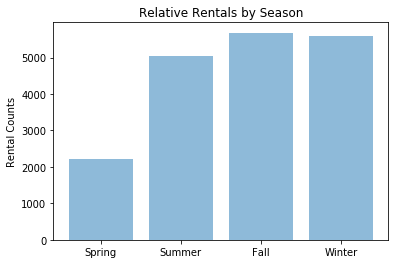

Avg rentals for each type of weather:  [9727.642201834862, 2096.2783018867926, 1736.2, 0]


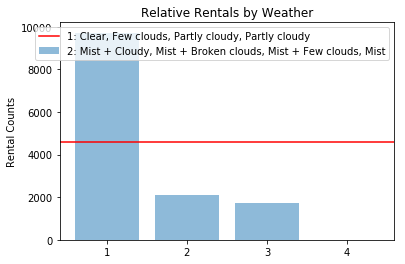

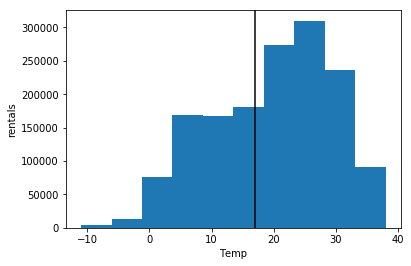

In [5]:
avg = [0, 0]

#Q1. How do the average rentals compare on weekdays vs weekend (training data set)?
#A. The average rentals on a non-working day were 4,461, while average rentals on a working day were
#   4,666. This was unexpected; you'd think that bike rentals would be hiked during the weekend.

objects = ('0', '1')
y_pos = np.arange(len(objects))

day = [train_data.loc[train_data['workingday'] == 0, 'rentals'].sum()]
day.append(train_data.loc[train_data['workingday'] == 1, 'rentals'].sum())
#print("Day = ", day)
number_of_entries = list(pd.value_counts(train_data['workingday'].values, sort=False))
number_of_entries = list(reversed(number_of_entries))
#print("Number of Entries = ", number_of_entries)
avg[0] = day[0] / number_of_entries[0]
avg[1] = day[1] / number_of_entries[1]
print("Avg rentals on a non-working day: ", avg[0])
print("Avg rentals on a working day: ", avg[1])
plt.bar(y_pos, avg, align='center', alpha=0.5)
plt.xticks(y_pos, ['Non-working Day', 'Working Day'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Weekend vs. Weekday')
plt.show()

#Q2. How do bike rentals vary on holidays vs. non-holidays?
#A. Avg rentals on holiday were 4,612 on average, but 4,199 on average for a non-holiday, about 10% different.
objects = ('0', '1')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['holiday'] == 0, 'rentals'].sum()]
day.append(train_data.loc[train_data['holiday'] == 1, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['holiday'].values, sort=False))
avg[0] = day[0] / number_of_entries[0]
avg[1] = day[1] / number_of_entries[1]
print("Avg rentals on holiday: ", avg[0])
print("Avg rentals on non-holiday: ", avg[1])
plt.bar(y_pos, avg, align='center', alpha=0.5)
plt.xticks(y_pos, ['Holiday', 'Non-holiday'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals Holidy vs. Non-holiday')
plt.show()

#Q3: How are rentals distributed by season?
#A: Spring has the lowest number, just over 2,000 per day. The other seasons see a multiple of that - on the order of
#5,000 per day (rounded).
avg_2 = [0, 0, 0, 0]
objects = ('1', '2', '3', '4')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['season'] == 1, 'rentals'].sum()]
day.append(train_data.loc[train_data['season'] == 2, 'rentals'].sum())
day.append(train_data.loc[train_data['season'] == 3, 'rentals'].sum())
day.append(train_data.loc[train_data['season'] == 4, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['season'].values, sort=False))
#number_of_entries = list(reversed(number_of_entries))
#print("Number of Entries = ", number_of_entries)
avg_2[0] = day[0] / number_of_entries[0]
avg_2[1] = day[1] / number_of_entries[1]
avg_2[2] = day[2] / number_of_entries[2]
avg_2[3] = day[3] / number_of_entries[3]
print("Avg rentals for each season: ", avg_2)
plt.bar(y_pos, avg_2, align='center', alpha=0.5)
plt.xticks(y_pos, ['Spring', 'Summer', 'Fall', 'Winter'])
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Season')
plt.show()

#Q4: How are rentals impacted by weather conditions?
#A: Unsurprisingly, rentals are highest when the weather is clear or at worst partly cloudy.
avg_2 = [0, 0, 0, 0]
objects = ('1', '2', '3', '4')
y_pos = np.arange(len(objects))
day = [train_data.loc[train_data['weather'] == 1, 'rentals'].sum()]
day.append(train_data.loc[train_data['weather'] == 2, 'rentals'].sum())
day.append(train_data.loc[train_data['weather'] == 3, 'rentals'].sum())
day.append(train_data.loc[train_data['weather'] == 4, 'rentals'].sum())
number_of_entries = list(pd.value_counts(train_data['weather'].values, sort=False))
mean = np.mean(train_data['rentals'])
#Note: the try..excepts below are due to the fact that some weather parameters are missing in the data,
#which was creating a division by zero.
try:
    avg_2[0] = day[0] / number_of_entries[0]
except:
    avg_2[0] = 0
try:
    avg_2[1] = day[1] / number_of_entries[1]
except:
    avg_2[1] = 0
try:
    avg_2[2] = day[2] / number_of_entries[2]
except:
    avg_2[2] = 0
try:
    avg_2[3] = day[3] / number_of_entries[3]
except:
    avg_2[3] = 0
print("Avg rentals for each type of weather: ", avg_2)
plt.bar(y_pos, avg_2, align='center', alpha=0.5)
plt.axhline(y=mean, color='r', linestyle='-')
plt.xticks(y_pos, objects)
plt.ylabel('Rental Counts')
plt.title('Relative Rentals by Weather')
plt.legend( ('1: Clear, Few clouds, Partly cloudy, Partly cloudy',
             '2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
             '3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
             '4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog') )
plt.show()

#Q5: How are rentals impacted by temperature?
#A: We prepared a histogram to demonstrate this impact. The bulk of rentals occurred when the temperature ranged
#from 20-40. We thought the histogram would be improved if each bar had a low-high range in the x-axis, but we could
#not get this feature to work.
mean = np.mean(train_data['temp'])
plt.hist(train_data['temp'], weights=train_data['rentals'])
plt.axvline(x=mean, color = "black")
plt.ylabel('rentals')
plt.xlabel('Temp')
plt.show()

In [6]:
factors = ['temp', 'atemp', 'humidity', 'windspeed']
i = 0
k_list = []
rtrain_list = []
rtest_list = []
for i, k in enumerate(factors):
        
    x = train_data[k]
    x = x.reshape(-1, 1)
    y = train_data['rentals']
    y = y.reshape(-1, 1)
      
    # Build graph
    plt.scatter(x, y)
    plt.xlabel(k)
    plt.ylabel('rentals')
    plt.title('Predicting Bike Rentals')
    plt.show()

AttributeError: ignored

In [0]:
# one hot encoding of test and training set
train_data = pd.get_dummies(train_data, prefix = ['season', 'month', 'day_of_week', 'weather'], columns = ['season', 'month', 'day_of_week', 'weather'], drop_first = True)
test_data = pd.get_dummies(test_data, prefix = ['season', 'month', 'day_of_week', 'weather'], columns = ['season', 'month', 'day_of_week', 'weather'], drop_first = True)

In [0]:
train_data.rename(index=str, columns={'season_2.0' : 'season_2'}, inplace=True)
train_data.rename(index=str, columns={'season_3.0' : 'season_3'}, inplace=True)
train_data.rename(index=str, columns={'season_4.0' : 'season_4'}, inplace=True)
train_data.rename(index=str, columns={'month_2.0' : 'month_2'}, inplace=True)
train_data.rename(index=str, columns={'month_3.0' : 'month_3'}, inplace=True)
train_data.rename(index=str, columns={'month_4.0' : 'month_4'}, inplace=True)
train_data.rename(index=str, columns={'month_5.0' : 'month_5'}, inplace=True)
train_data.rename(index=str, columns={'month_6.0' : 'month_6'}, inplace=True)
train_data.rename(index=str, columns={'month_7.0' : 'month_7'}, inplace=True)
train_data.rename(index=str, columns={'month_8.0' : 'month_8'}, inplace=True)
train_data.rename(index=str, columns={'month_9.0' : 'month_9'}, inplace=True)
train_data.rename(index=str, columns={'month_10.0' : 'month_10'}, inplace=True)
train_data.rename(index=str, columns={'month_11.0' : 'month_11'}, inplace=True)
train_data.rename(index=str, columns={'month_12.0' : 'month_12'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_1.0' : 'day_of_week_1'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_2.0' : 'day_of_week_2'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_3.0' : 'day_of_week_3'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_4.0' : 'day_of_week_4'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_5.0' : 'day_of_week_5'}, inplace=True)
train_data.rename(index=str, columns={'day_of_week_6.0' : 'day_of_week_6'}, inplace=True)
train_data.rename(index=str, columns={'weather_2.0' : 'weather_2'}, inplace=True)
train_data.rename(index=str, columns={'weather_3.0' : 'weather_3'}, inplace=True)
train_data.columns

test_data.rename(index=str, columns={'season_2.0' : 'season_2'}, inplace=True)
test_data.rename(index=str, columns={'season_3.0' : 'season_3'}, inplace=True)
test_data.rename(index=str, columns={'season_4.0' : 'season_4'}, inplace=True)
test_data.rename(index=str, columns={'month_2.0' : 'month_2'}, inplace=True)
test_data.rename(index=str, columns={'month_3.0' : 'month_3'}, inplace=True)
test_data.rename(index=str, columns={'month_4.0' : 'month_4'}, inplace=True)
test_data.rename(index=str, columns={'month_5.0' : 'month_5'}, inplace=True)
test_data.rename(index=str, columns={'month_6.0' : 'month_6'}, inplace=True)
test_data.rename(index=str, columns={'month_7.0' : 'month_7'}, inplace=True)
test_data.rename(index=str, columns={'month_8.0' : 'month_8'}, inplace=True)
test_data.rename(index=str, columns={'month_9.0' : 'month_9'}, inplace=True)
test_data.rename(index=str, columns={'month_10.0' : 'month_10'}, inplace=True)
test_data.rename(index=str, columns={'month_11.0' : 'month_11'}, inplace=True)
test_data.rename(index=str, columns={'month_12.0' : 'month_12'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_1.0' : 'day_of_week_1'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_2.0' : 'day_of_week_2'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_3.0' : 'day_of_week_3'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_4.0' : 'day_of_week_4'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_5.0' : 'day_of_week_5'}, inplace=True)
test_data.rename(index=str, columns={'day_of_week_6.0' : 'day_of_week_6'}, inplace=True)
test_data.rename(index=str, columns={'weather_2.0' : 'weather_2'}, inplace=True)
test_data.rename(index=str, columns={'weather_3.0' : 'weather_3'}, inplace=True)

In [10]:
train_data

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
0,0,0.0,1.0,24.0,26.0,76.5833,0.118167,6073.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.0,1.0,15.0,19.0,73.3750,0.174129,6606.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,0.0,1.0,26.0,28.0,56.9583,0.253733,7363.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,0.0,0.0,0.0,4.0,58.6250,0.169779,2431.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,4,0.0,1.0,23.0,23.0,91.7083,0.097021,1996.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
5,5,0.0,1.0,24.0,26.0,69.7083,0.342667,4451.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,6,0.0,1.0,7.0,11.0,33.3478,0.347835,5315.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7,7,0.0,1.0,23.0,26.0,50.7083,0.269283,4891.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,8,0.0,0.0,23.0,26.0,50.1667,0.247521,8714.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
9,9,0.0,1.0,30.0,30.0,61.9583,0.169771,7347.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
train_data.describe()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,165.000000,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.259819,0.265861,0.256798,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,0.099698,0.090634,0.093656,0.066465,0.175227,0.135952,0.123867,0.123867,0.145015,0.135952,0.329305,0.030211
std,95.695698,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.439199,0.442459,0.437528,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,0.300050,0.287523,0.291790,0.249471,0.380736,0.343256,0.329929,0.329929,0.352649,0.343256,0.470672,0.171428
min,0.000000,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.500000,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,165.000000,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,247.500000,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,330.000000,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
mean_temp = train_data.temp.dropna().mean()
sd_temp = train_data.temp.dropna().std()
mean_atemp = train_data.atemp.dropna().mean()
sd_atemp = train_data.atemp.dropna().std()
mean_humidity = train_data.humidity.dropna().mean()
sd_humidity = train_data.humidity.dropna().std()
mean_windspeed = train_data.windspeed.dropna().mean()
sd_windspeed = train_data.windspeed.dropna().std()

train_data['temp'] = train_data['temp'].apply(lambda x: (x - mean_temp ) / (sd_temp))
train_data['atemp'] = train_data['atemp'].apply(lambda x: (x - mean_atemp ) / (sd_atemp))
train_data['humidity'] = train_data['humidity'].apply(lambda x: (x - mean_humidity ) / (sd_humidity))
train_data['windspeed'] = train_data['windspeed'].apply(lambda x: (x - mean_windspeed ) / (sd_windspeed))

train_data

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,rentals,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_2,weather_3
0,0,0.0,1.0,0.623798,0.650106,0.920664,-0.928758,6073.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.0,1.0,-0.180310,-0.054759,0.696852,-0.213502,6606.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,0.0,1.0,0.802489,0.851495,-0.448383,0.803926,7363.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,0.0,0.0,-1.520492,-1.565182,-0.332113,-0.269099,2431.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,4,0.0,1.0,0.534453,0.348021,1.975789,-1.199027,1996.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
5,5,0.0,1.0,0.623798,0.650106,0.441062,1.940601,4451.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,6,0.0,1.0,-0.895074,-0.860318,-2.095460,2.006654,5315.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7,7,0.0,1.0,0.534453,0.650106,-0.884385,1.002672,4891.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,8,0.0,0.0,0.534453,0.650106,-0.922167,0.724530,8714.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
9,9,0.0,1.0,1.159871,1.052885,-0.099581,-0.269202,7347.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
train_data.columns
test_data.columns

Index(['Unnamed: 0', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'rentals', 'season_2', 'season_3', 'season_4', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'weather_2', 'weather_3'],
      dtype='object')

In [0]:
# normalize test data 
test_data['temp'] = test_data['temp'].apply(lambda x: (x - mean_temp ) / (sd_temp))
test_data['atemp'] = test_data['atemp'].apply(lambda x: (x - mean_atemp ) / (sd_atemp))
test_data['humidity'] = test_data['humidity'].apply(lambda x: (x - mean_humidity ) / (sd_humidity))
test_data['windspeed'] = test_data['windspeed'].apply(lambda x: (x - mean_windspeed ) / (sd_windspeed))

In [0]:
y_train = train_data['rentals'].values
X_train = train_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values

y_test = test_data['rentals'].values
X_test = test_data[['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
                 'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
                 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
                 'weather_3']].values

your answers here

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [16]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

(331, 28) (331, 1) (400, 28) (400, 1)


In [21]:
X_train_lm = X_train
y_train_lm = y_train
from sklearn import linear_model

lm_1 = linear_model.LinearRegression(fit_intercept=False)
lm_1.fit(X_train, y_train)

y_pred = lm_1.predict(X_test)

print('The equation of the regression plane is: {} + {}^T . x'.format(lm_1.intercept_, lm_1.coef_))

The equation of the regression plane is: 0.0 + [[  647.42366924   767.8015386   -139.15154697   345.06778312
   -608.00243611  -233.08309201   607.08510779  1449.56183869
   1527.21023169  1910.09654974  2607.48033277  3416.97623576
   3721.95208939  3221.13055984  2795.66450314  2936.26395522
   3647.20099134  3103.03228137  2031.6484638   1666.20196057
     48.50940668    16.23889168   465.00451356   480.31105598
    405.16133994  1038.20857432   250.72200529 -1365.57968946]]^T . x


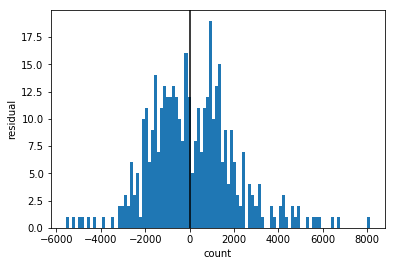

In [22]:
# Residual plot
plt.hist(y_test - y_pred, bins=100)
plt.axvline(x=0, color = "black")
plt.ylabel('residual')
plt.xlabel('count')
plt.show()

In [23]:
train_MSE= np.mean((y_train - lm_1.predict(X_train))**2)
test_MSE= np.mean((y_test - lm_1.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm_1.score(X_train, y_train)
test_R_sq = lm_1.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE is 1959336.9385256353, the test MSE is 3784524.381243885
The train R^2 is 0.47529173170753874, the test R^2 is 0.13359026090270565


In [24]:
# statsmodel regression
# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
# build the OLS model from the training data
smm = sm.OLS(y_train, X)

#save regression info in results_sm
results_sm = smm.fit()

print(results_sm)

In [25]:
print(results_sm.summary())
print('Parameters: ', results_sm.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           6.56e-42
Time:                        09:53:14   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3681.7765    433.655      8.490      0.0

your answers here

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

   Unnamed: 0  holiday  workingday  ...  day_of_week_6  weather_2  weather_3
0           0      0.0         1.0  ...              0          1          0
1           1      0.0         1.0  ...              0          0          0
2           2      0.0         1.0  ...              0          0          0
3           3      0.0         0.0  ...              0          0          0
4           4      0.0         1.0  ...              0          0          1

[5 rows x 30 columns]
 1.00 -0.26  0.02  0.02  0.00 -0.02  0.01 -0.04  0.01  0.02 -0.05  0.01  0.05 -0.05 -0.00 -0.06 -0.01  0.00  0.06  0.02  0.36 -0.07 -0.07 -0.02 -0.08 -0.07 -0.06 -0.03 
-0.26  1.00  0.06  0.06  0.09 -0.03  0.02  0.01 -0.03  0.06  0.05 -0.11  0.03  0.07 -0.06  0.04  0.04 -0.03 -0.04 -0.05  0.15  0.28  0.26  0.24  0.29 -0.57  0.11  0.01 
 0.02  0.06  1.00  0.98  0.14 -0.15  0.13  0.66 -0.23 -0.28 -0.19 -0.06  0.18  0.26  0.44  0.34  0.20 -0.04 -0.24 -0.28  0.03 -0.02  0.08  0.01 -0.01 -0.05 -0.10 -0.08 
 0.02  0

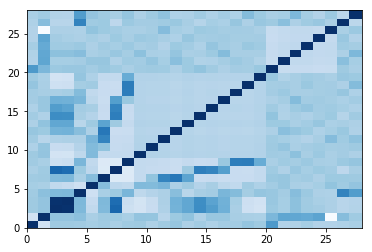

 1.00 -0.26  0.02  0.00 -0.02  0.02 -0.05  0.01  0.05 -0.05 -0.00 -0.06 -0.01  0.00  0.06  0.02  0.36 -0.07 -0.07 -0.02 -0.08 -0.07 -0.06 -0.03 
-0.26  1.00  0.06  0.09 -0.03  0.06  0.05 -0.11  0.03  0.07 -0.06  0.04  0.04 -0.03 -0.04 -0.05  0.15  0.28  0.26  0.24  0.29 -0.57  0.11  0.01 
 0.02  0.06  1.00  0.14 -0.15 -0.28 -0.19 -0.06  0.18  0.26  0.44  0.34  0.20 -0.04 -0.24 -0.28  0.03 -0.02  0.08  0.01 -0.01 -0.05 -0.10 -0.08 
 0.00  0.09  0.14  1.00 -0.24 -0.14 -0.09 -0.05  0.11 -0.11 -0.02 -0.01  0.16  0.12 -0.01  0.05  0.04 -0.00  0.11  0.03 -0.05 -0.06  0.50  0.34 
-0.02 -0.03 -0.15 -0.24  1.00  0.13  0.13  0.17 -0.05  0.02 -0.08 -0.02 -0.12 -0.14  0.01 -0.06 -0.00  0.05 -0.03 -0.05 -0.02  0.07  0.01  0.06 
 0.02  0.06 -0.28 -0.14  0.13  1.00 -0.08 -0.08 -0.09 -0.07 -0.09 -0.08 -0.09 -0.08 -0.09 -0.07  0.00  0.00  0.08 -0.03  0.03 -0.04 -0.01 -0.05 
-0.05  0.05 -0.19 -0.09  0.13 -0.08  1.00 -0.08 -0.10 -0.08 -0.09 -0.09 -0.10 -0.09 -0.09 -0.08  0.02  0.05 -0.04 -0.00  0.01 -0.0

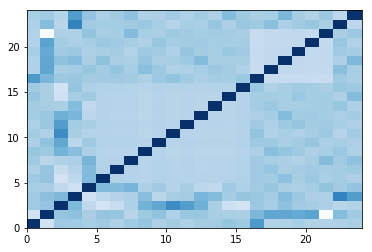

In [26]:
print(train_data.head())
dimensions = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 
    'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
    'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
    'weather_3']
corr_matrix = np.corrcoef(train_data[dimensions].T)
for y in range(0, len(corr_matrix)):
    for x in range(0, len(corr_matrix)):
        print ("%5.2f " % corr_matrix[y][x], end="")
    print()
heatmap = plt.pcolor(corr_matrix, cmap=matplotlib.cm.Blues)
plt.show()

dimensions_2 = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'month_2', 'month_3', 'month_4', 'month_5', 
    'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_1', 
    'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 
    'weather_3']
corr_matrix_2 = np.corrcoef(train_data[dimensions_2].T)
for y in range(0, len(corr_matrix_2)):
    for x in range(0, len(corr_matrix_2)):
        print ("%5.2f " % corr_matrix_2[y][x], end="")
    print()
heatmap_2 = plt.pcolor(corr_matrix_2, cmap=matplotlib.cm.Blues)
plt.show()

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [0]:
# your code here
dimensions_3 = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'season_2', 'season_3', 'season_4', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'weather_2', 'weather_3']
y = train_data.rentals
X = train_data[dimensions_3]

# We'll use a slightly narrower feature set going into the stepwise algorithm, 
# having pruned the months and atemp due to covariance

In [28]:
# step forward model selection
# gets the bic of a given model, creates dict entry of model with its bic
def get_bic(predictors):
    model = sm.OLS(y, X[list(predictors)]).fit()
    return {"model": model, "bic" : model.bic}

# determine the best of a given set of models
def best_of(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(get_bic(predictors+[p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models['bic'].argmin()]
    return best_model

models = pd.DataFrame(columns=["bic", "model"])
predictors = []

# go through predictors stepwise until adding more predictors raises bic
for i in range(1, len(X.columns)+1):
    models.loc[i] = best_of(predictors) 
    predictors = models.loc[i]["model"].model.exog_names
    if i == 1:
        best_score = models.loc[i]["bic"]        
    else:
        if models.loc[i]["bic"] < best_score:
            best_score = models.loc[i]["bic"]        
        if models.loc[i]["bic"] > best_score:
            best_model = models.loc[i-1]
            print(best_model)
            break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  if sys.path[0] == '':


bic                                                5885.28
model    <statsmodels.regression.linear_model.Regressio...
Name: 9, dtype: object


In [29]:
print(best_model[1].summary())

# save model for further use in cross-validation
forward_step_model = best_model[1]

                                 OLS Regression Results                                
Dep. Variable:                rentals   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              301.9
Date:                Fri, 09 Aug 2019   Prob (F-statistic):                   3.49e-151
Time:                        09:54:43   Log-Likelihood:                         -2916.5
No. Observations:                 331   AIC:                                      5851.
Df Residuals:                     322   BIC:                                      5885.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [0]:
dimensions_4 = ['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']

In [0]:
X_train = train_data[['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']].values

X_test = test_data[['holiday', 'workingday', 'temp', 'humidity', 'season_2', 'season_3', 'day_of_week_6', 'weather_3', 'season_4']].values


lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [33]:
train_MSE= np.mean((y_train - lm.predict(X_train))**2)
test_MSE= np.mean((y_test - lm.predict(X_test))**2)
print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = lm.score(X_train, y_train)
test_R_sq = lm.score(X_test, y_test)
print('The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

The train MSE is 1821071.327748787, the test MSE is 3175895.521393405
The train R^2 is 0.5123191095763557, the test R^2 is 0.2729266526256783


your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [0]:
# our models - lm_1 all predictors
#              lm   pruned predictors

# first model
scores = cross_val_score(lm, X_train_lm, y_train_lm, cv=10)
lm_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_avg)
print

In [0]:
# second model
scores = cross_val_score(lm_1, X_train, y_train, cv=10)
lm_1_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_1_avg)

your answers here